In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import json
import torch
from isometry_pursuit.vendor import HParams
from isometry_pursuit.atomic_geometry import get_atoms3_full, get_atoms4_full, get_atoms_4
import itertools

print('Loading ethanol data')

config_path = "/Users/samsonkoelle/montlake/experiments/configs/ethanol_full.json"
raw_data = "/Users/samsonkoelle/thesis_data/raw_data/ethanol.mat"

positions = np.load('/Users/samsonkoelle/positions.npy')
randomindices = np.load('/Users/samsonkoelle/indices.npy')

np.random.seed(1234)
random.seed(1234)

config = {}

with open(config_path) as f:
    config.update(json.load(f))

hparams = HParams(**config)

Loading ethanol data


In [2]:
d = hparams.d
n_components = hparams.n_components
atoms2_feat = hparams.atoms2_feat
atoms3_feat = hparams.atoms3_feat
atoms4_feat = hparams.atoms4_feat
atoms2_dict = hparams.atoms2_dict
atoms3_dict = hparams.atoms3_dict
atoms4_dict = hparams.atoms4_dict
diagram = hparams.diagram

ii = np.asarray(hparams.ii)
jj = np.asarray(hparams.jj)
#load geometric features
natoms = positions.shape[1]
n = positions.shape[0]
atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2)))
atoms2full = atoms2
atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3)))
atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4)))
atoms3full = get_atoms3_full(atoms3)
atoms4full = get_atoms4_full(atoms4)

if atoms2_feat:
    atoms2_feats = atoms2full
else:
    atoms2_feats = np.asarray([])

if atoms3_feat:
    atoms3_feats = atoms3full
else:
    atoms3_feats = np.asarray([])

if atoms4_feat:
    atoms4_feats = atoms4full
else:
    atoms4_feats = np.asarray([])

In [3]:
data = np.load('/Users/samsonkoelle/ethanolanglesfull_0524.npy')
n_neighbors = hparams.n_neighbors
atoms4_dicts= get_atoms_4(natoms, ii, jj)[0]
if atoms2_dict:
    atoms2_dicts = atoms2full
else:
    atoms2_dicts = np.asarray([])
if atoms3_dict:
    atoms3_dicts = atoms3full
else:
    atoms3_dicts = np.asarray([])


In [4]:
from scipy import sparse
from isometry_pursuit.transformation import exponential_transformation
from isometry_pursuit.manifold import local_pca
from isometry_pursuit.atomic_geometry import get_D_feats_feats

nsel = 100
dimension = 2
p = atoms4full.shape[0]

selected_points = np.random.choice(range(50000),nsel)
dg_x = np.asarray([get_D_feats_feats(positions[selected_points[i]],
           atoms2in = atoms2_feats,
           atoms3in = atoms3_feats,
           atoms4in = atoms4_feats,
           atoms2out = atoms2_dicts,
           atoms3out = atoms3_dicts,
           atoms4out = atoms4full) for i in range(nsel)])                           

power = 1


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [5]:
dg_M = np.zeros((nsel, dimension, p))
for i, sp in enumerate(selected_points):
    tangent_bases = local_pca(data, sp, n_neighbors, dimension)
    # NOTE (Sam): normalization prior to projection once again in the manifold case.
    dg_x_normalized = exponential_transformation(dg_x[i], power)
    dg_M[i] = np.einsum('b p, b d -> d p', dg_x_normalized, tangent_bases)

In [12]:
from isometry_pursuit.experiment import analyze_data
from tqdm import tqdm
import pandas as pd

In [15]:
D = 2

losses = []
support_cardinalities_basis_pursuit = []
two_stage_losses = []
random_two_stage_losses = []
greedy_multitask_norms_two_stage = []
brute_isometry_losses = []
brute_losses = []


for i in tqdm(range(100)):
    (
        loss,
        support_cardinality_basis_pursuit,
        two_stage_loss,
        random_two_stage_loss,
        greedy_multitask_norm_two_stage,
        brute_loss,
        brute_isometry_loss,
    ) = analyze_data(dg_M[i], compute_brute=False, power=1.0)
    losses.append(loss)
    support_cardinalities_basis_pursuit.append(support_cardinality_basis_pursuit)
    two_stage_losses.append(two_stage_loss)
    greedy_multitask_norms_two_stage.append(greedy_multitask_norm_two_stage)
    random_two_stage_losses.append(random_two_stage_loss)
    brute_losses.append(brute_loss)
    brute_isometry_losses.append(brute_isometry_loss)
    results_df = pd.DataFrame(
        {
            "Losses": losses,
            "Support Cardinalities (Basis Pursuit)": support_cardinalities_basis_pursuit,
            "Two-Stage Losses": two_stage_losses,
            "Random Two-Stage Losses": random_two_stage_losses,
            "Greedy Multitask Norms (Two-Stage)": greedy_multitask_norms_two_stage,
            "Brute Isometry Losses": brute_isometry_losses,
            "Brute Losses": brute_losses,
        }
    )

  0%|                                                                                                 | 0/100 [00:00<?, ?it/s]/Users/samsonkoelle/isometry-pursuit/isometry_pursuit/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
/Users/samsonkoelle/isometry-pursuit/isometry_pursuit/transformation.py:27: RuntimeWarning: overflow encountered in exp
  exp_values = ((np.exp(norms) + np.exp(norms ** (-1))) ** (-1)) * 2 * np.e
/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10556.13it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7521.17it/s]
  1%|▉                                                                                        | 1/100 [00:09<14:57,  9.07s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5868.90it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6123.07it/s]
  2%|█▊                                                                                       | 2/100 [00:17<14:40,  8.98s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12879.13it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7332.70it/s]
  3%|██▋                                                                                      | 3/100 [00:26<14:03,  8.70s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8377.44it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9649.47it/s]
  4%|███▌                                                                                     | 4/100 [00:35<14:14,  8.91s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11543.96it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5822.73it/s]
  5%|████▍                                                                                    | 5/100 [00:45<14:24,  9.10s/it]

Brute force complexity 75466 from D=2 and nbp=389
Computing brute force solution for dictionary dimension 389 and target_dimension 2



0it [00:00, ?it/s]
3239it [00:00, 32388.02it/s]
6525it [00:00, 32663.15it/s]
9792it [00:00, 31579.37it/s]
13114it [00:00, 32212.07it/s]
16394it [00:00, 32419.23it/s]
19639it [00:00, 31859.64it/s]
22987it [00:00, 32377.58it/s]
26229it [00:00, 32389.69it/s]
29471it [00:00, 30946.45it/s]
32580it [00:01, 29675.89it/s]
35564it [00:01, 29276.97it/s]
38503it [00:01, 28795.90it/s]
41390it [00:01, 28137.65it/s]
44210it [00:01, 28050.61it/s]
47019it [00:01, 27833.16it/s]
49822it [00:01, 27887.56it/s]
52671it [00:01, 28062.49it/s]
55511it [00:01, 28161.86it/s]
58382it [00:01, 28322.84it/s]
61216it [00:02, 28179.65it/s]
64059it [00:02, 28253.02it/s]
66885it [00:02, 23866.59it/s]
69542it [00:02, 24579.60it/s]
72398it [00:02, 25670.63it/s]
75466it [00:02, 28558.76it/s]


Computing brute force solution for dictionary dimension 389 and target_dimension 2



0it [00:00, ?it/s]
3137it [00:00, 31365.39it/s]
6274it [00:00, 31180.71it/s]
9393it [00:00, 30993.96it/s]
12493it [00:00, 30824.49it/s]
15623it [00:00, 30993.05it/s]
18792it [00:00, 31227.40it/s]
21915it [00:00, 31211.98it/s]
25037it [00:00, 30671.20it/s]
28107it [00:00, 30599.79it/s]
31169it [00:01, 30198.84it/s]
34340it [00:01, 30496.81it/s]
37391it [00:01, 30487.34it/s]
40441it [00:01, 30323.82it/s]
43556it [00:01, 30569.82it/s]
46631it [00:01, 30622.67it/s]
49694it [00:01, 30602.23it/s]
52755it [00:01, 30581.93it/s]
55814it [00:01, 30347.06it/s]
58910it [00:01, 30527.41it/s]
61984it [00:02, 30589.14it/s]
65057it [00:02, 30629.71it/s]
68214it [00:02, 30909.35it/s]
71306it [00:02, 30481.67it/s]
75466it [00:02, 30671.47it/s]
  6%|█████▎                                                                                   | 6/100 [00:59<16:55, 10.81s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9151.21it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9404.27it/s]
  7%|██████▏                                                                                  | 7/100 [01:09<16:23, 10.58s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12145.67it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6536.58it/s]
  8%|███████                                                                                  | 8/100 [01:18<15:26, 10.07s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5907.47it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5485.14it/s]
  9%|████████                                                                                 | 9/100 [01:28<15:11, 10.02s/it]

Brute force complexity 98346 from D=2 and nbp=444
Computing brute force solution for dictionary dimension 444 and target_dimension 2



0it [00:00, ?it/s]
2875it [00:00, 28747.35it/s]
5798it [00:00, 29025.49it/s]
8701it [00:00, 28770.23it/s]
11579it [00:00, 28772.16it/s]
14457it [00:00, 28582.52it/s]
17352it [00:00, 28703.72it/s]
20227it [00:00, 28715.60it/s]
23099it [00:00, 28669.79it/s]
26027it [00:00, 28855.14it/s]
28913it [00:01, 28611.69it/s]
31775it [00:01, 23786.19it/s]
34605it [00:01, 24980.25it/s]
37526it [00:01, 26141.24it/s]
40419it [00:01, 26924.86it/s]
43290it [00:01, 27435.60it/s]
46126it [00:01, 27703.90it/s]
49097it [00:01, 28290.25it/s]
52235it [00:01, 29201.19it/s]
55447it [00:01, 30065.63it/s]
58555it [00:02, 30367.23it/s]
61704it [00:02, 30699.13it/s]
64789it [00:02, 30740.72it/s]
68115it [00:02, 31493.27it/s]
71305it [00:02, 31612.39it/s]
74515it [00:02, 31753.53it/s]
77880it [00:02, 32318.73it/s]
81203it [00:02, 32589.32it/s]
84463it [00:02, 32376.64it/s]
87821it [00:02, 32734.93it/s]
91096it [00:03, 32393.45it/s]
94337it [00:03, 31881.05it/s]
98346it [00:03, 29732.24it/s]


Computing brute force solution for dictionary dimension 444 and target_dimension 2



0it [00:00, ?it/s]
3573it [00:00, 35726.71it/s]
7146it [00:00, 34929.76it/s]
10651it [00:00, 34982.91it/s]
14151it [00:00, 34631.77it/s]
17615it [00:00, 34484.00it/s]
21064it [00:00, 34440.47it/s]
24607it [00:00, 34758.36it/s]
28142it [00:00, 34943.69it/s]
31637it [00:00, 34810.07it/s]
35119it [00:01, 33404.03it/s]
38471it [00:01, 33244.75it/s]
41865it [00:01, 33448.25it/s]
45216it [00:01, 33388.87it/s]
48692it [00:01, 33788.97it/s]
52094it [00:01, 33855.77it/s]
55527it [00:01, 33994.49it/s]
58959it [00:01, 34091.38it/s]
62438it [00:01, 34298.27it/s]
65869it [00:01, 34126.04it/s]
69283it [00:02, 32171.60it/s]
72831it [00:02, 33119.53it/s]
76324it [00:02, 33645.19it/s]
79725it [00:02, 33751.14it/s]
83193it [00:02, 34023.64it/s]
86604it [00:02, 33965.42it/s]
90155it [00:02, 34423.18it/s]
93602it [00:02, 34378.45it/s]
98346it [00:02, 34032.94it/s]
 10%|████████▊                                                                               | 10/100 [01:44<17:44, 11.83s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15215.13it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5318.22it/s]
 11%|█████████▋                                                                              | 11/100 [01:53<16:15, 10.96s/it]

Brute force complexity 35511 from D=2 and nbp=267
Computing brute force solution for dictionary dimension 267 and target_dimension 2



0it [00:00, ?it/s]
3280it [00:00, 32797.06it/s]
6560it [00:00, 32715.81it/s]
9832it [00:00, 32152.86it/s]
13168it [00:00, 32622.48it/s]
16432it [00:00, 32520.02it/s]
19685it [00:00, 32365.94it/s]
23177it [00:00, 33188.86it/s]
26497it [00:00, 32885.88it/s]
29787it [00:00, 32746.85it/s]
35511it [00:01, 32679.97it/s]


Computing brute force solution for dictionary dimension 267 and target_dimension 2



0it [00:00, ?it/s]
3503it [00:00, 35028.61it/s]
7006it [00:00, 34173.86it/s]
10475it [00:00, 34403.40it/s]
13948it [00:00, 34528.42it/s]
17402it [00:00, 33904.57it/s]
20795it [00:00, 32722.67it/s]
24075it [00:00, 32386.43it/s]
27319it [00:00, 31876.97it/s]
30511it [00:00, 31649.18it/s]
35511it [00:01, 32781.58it/s]
 12%|██████████▌                                                                             | 12/100 [02:03<15:59, 10.91s/it]

Brute force complexity 97020 from D=2 and nbp=441
Computing brute force solution for dictionary dimension 441 and target_dimension 2



0it [00:00, ?it/s]
2839it [00:00, 28385.09it/s]
5678it [00:00, 28382.50it/s]
8517it [00:00, 27999.60it/s]
11318it [00:00, 27813.96it/s]
14194it [00:00, 28150.99it/s]
17042it [00:00, 28259.48it/s]
19869it [00:00, 28255.83it/s]
22707it [00:00, 28292.20it/s]
25589it [00:00, 28453.98it/s]
28435it [00:01, 28227.63it/s]
31356it [00:01, 28524.17it/s]
34281it [00:01, 28743.23it/s]
37156it [00:01, 28672.30it/s]
40083it [00:01, 28851.13it/s]
42969it [00:01, 28405.06it/s]
45812it [00:01, 23715.07it/s]
48675it [00:01, 25000.26it/s]
51890it [00:01, 26944.96it/s]
55142it [00:01, 28502.87it/s]
58262it [00:02, 29270.99it/s]
61249it [00:02, 29317.56it/s]
64223it [00:02, 29066.22it/s]
67159it [00:02, 29090.47it/s]
70089it [00:02, 28663.22it/s]
72971it [00:02, 28524.33it/s]
76140it [00:02, 29449.79it/s]
79095it [00:02, 29333.24it/s]
82127it [00:02, 29621.43it/s]
85113it [00:02, 29689.94it/s]
88086it [00:03, 29269.10it/s]
91017it [00:03, 29176.12it/s]
97020it [00:03, 28542.18it/s]


Computing brute force solution for dictionary dimension 441 and target_dimension 2



0it [00:00, ?it/s]
3199it [00:00, 31984.01it/s]
6718it [00:00, 33868.52it/s]
10215it [00:00, 34369.56it/s]
13652it [00:00, 34037.28it/s]
17057it [00:00, 33747.81it/s]
20655it [00:00, 34496.36it/s]
24106it [00:00, 34497.33it/s]
27691it [00:00, 34924.17it/s]
31243it [00:00, 35102.41it/s]
34754it [00:01, 33862.34it/s]
38182it [00:01, 33986.26it/s]
41774it [00:01, 34561.64it/s]
45279it [00:01, 34702.04it/s]
48801it [00:01, 34856.11it/s]
52290it [00:01, 34781.68it/s]
55819it [00:01, 34932.64it/s]
59331it [00:01, 34985.90it/s]
62914it [00:01, 35235.89it/s]
66439it [00:01, 35187.51it/s]
69959it [00:02, 35017.16it/s]
73462it [00:02, 34914.48it/s]
76954it [00:02, 34609.64it/s]
80454it [00:02, 34725.05it/s]
83955it [00:02, 34807.65it/s]
87514it [00:02, 35040.77it/s]
91019it [00:02, 34912.63it/s]
97020it [00:02, 34696.58it/s]
 13%|███████████▍                                                                            | 13/100 [02:19<18:08, 12.51s/it]

Brute force complexity 114960 from D=2 and nbp=480
Computing brute force solution for dictionary dimension 480 and target_dimension 2



0it [00:00, ?it/s]
3189it [00:00, 31883.65it/s]
6471it [00:00, 32431.19it/s]
9729it [00:00, 32497.98it/s]
13059it [00:00, 32810.70it/s]
16341it [00:00, 32624.76it/s]
19675it [00:00, 32866.31it/s]
23026it [00:00, 33073.50it/s]
26358it [00:00, 33149.61it/s]
29674it [00:00, 32405.12it/s]
32920it [00:01, 32421.37it/s]
36254it [00:01, 32698.77it/s]
39526it [00:01, 32515.71it/s]
42780it [00:01, 32491.01it/s]
46031it [00:01, 32477.30it/s]
49396it [00:01, 32828.31it/s]
52704it [00:01, 32901.50it/s]
55995it [00:01, 32401.77it/s]
59373it [00:01, 32808.39it/s]
62656it [00:01, 32722.99it/s]
65997it [00:02, 32924.60it/s]
69291it [00:02, 32678.66it/s]
72594it [00:02, 32781.17it/s]
75873it [00:02, 32557.59it/s]
79158it [00:02, 32643.90it/s]
82428it [00:02, 32659.82it/s]
85695it [00:02, 32320.99it/s]
88929it [00:02, 32145.69it/s]
92309it [00:02, 32635.68it/s]
95574it [00:02, 32577.79it/s]
98846it [00:03, 32618.92it/s]
102109it [00:03, 32435.44it/s]
105354it [00:03, 32416.24it/s]
108757it [00:03, 3289

Computing brute force solution for dictionary dimension 480 and target_dimension 2



0it [00:00, ?it/s]
3524it [00:00, 35230.88it/s]
7048it [00:00, 35035.51it/s]
10562it [00:00, 35079.24it/s]
14070it [00:00, 34714.10it/s]
17542it [00:00, 32703.25it/s]
21066it [00:00, 33526.44it/s]
24637it [00:00, 34218.41it/s]
28151it [00:00, 34503.22it/s]
31611it [00:00, 34444.09it/s]
35196it [00:01, 34870.48it/s]
38688it [00:01, 34704.45it/s]
42246it [00:01, 34966.10it/s]
45746it [00:01, 33398.05it/s]
49102it [00:01, 33326.77it/s]
52642it [00:01, 33932.32it/s]
56129it [00:01, 34207.03it/s]
59581it [00:01, 34298.91it/s]
63037it [00:01, 34374.11it/s]
66496it [00:01, 34435.84it/s]
70107it [00:02, 34933.17it/s]
73677it [00:02, 35160.67it/s]
77210it [00:02, 35210.61it/s]
80733it [00:02, 34759.21it/s]
84211it [00:02, 34675.18it/s]
87680it [00:02, 34570.03it/s]
91168it [00:02, 34661.21it/s]
94635it [00:02, 34388.39it/s]
98226it [00:02, 34834.54it/s]
101712it [00:02, 34839.73it/s]
105197it [00:03, 34471.02it/s]
108763it [00:03, 34823.18it/s]
114960it [00:03, 34496.09it/s]
 14%|████████████▎

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11949.58it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8192.00it/s]
 15%|█████████████▏                                                                          | 15/100 [02:44<17:10, 12.12s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3417.41it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12483.05it/s]
 16%|██████████████                                                                          | 16/100 [02:53<15:23, 10.99s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6768.65it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10791.52it/s]
 17%|██████████████▉                                                                         | 17/100 [03:01<14:11, 10.26s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6332.62it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11305.40it/s]
 18%|███████████████▊                                                                        | 18/100 [03:10<13:31,  9.89s/it]

Brute force complexity 90525 from D=2 and nbp=426
Computing brute force solution for dictionary dimension 426 and target_dimension 2



0it [00:00, ?it/s]
3057it [00:00, 30567.84it/s]
6425it [00:00, 32393.67it/s]
9665it [00:00, 31613.26it/s]
12829it [00:00, 31233.98it/s]
15954it [00:00, 30495.28it/s]
19007it [00:00, 29720.27it/s]
21983it [00:00, 29145.66it/s]
25210it [00:00, 30101.86it/s]
28226it [00:00, 29508.87it/s]
31260it [00:01, 29754.94it/s]
34436it [00:01, 30352.32it/s]
37476it [00:01, 29812.85it/s]
40462it [00:01, 29486.68it/s]
43414it [00:01, 29271.61it/s]
46360it [00:01, 29326.25it/s]
49416it [00:01, 29688.16it/s]
52387it [00:01, 20830.95it/s]
54832it [00:02, 20896.38it/s]
57176it [00:02, 19827.81it/s]
60205it [00:02, 22342.68it/s]
63074it [00:02, 23964.45it/s]
65763it [00:02, 24745.78it/s]
68359it [00:02, 22650.57it/s]
71201it [00:02, 24166.65it/s]
74090it [00:02, 25455.36it/s]
76920it [00:02, 26252.42it/s]
79772it [00:02, 26900.49it/s]
82675it [00:03, 27517.09it/s]
85543it [00:03, 27855.49it/s]
90525it [00:03, 26976.74it/s]


Computing brute force solution for dictionary dimension 426 and target_dimension 2



0it [00:00, ?it/s]
3063it [00:00, 30627.25it/s]
6126it [00:00, 30472.39it/s]
9174it [00:00, 23256.32it/s]
12253it [00:00, 25754.59it/s]
15335it [00:00, 27381.73it/s]
18454it [00:00, 28578.61it/s]
21563it [00:00, 29356.70it/s]
24559it [00:00, 29423.76it/s]
27681it [00:00, 29969.26it/s]
30745it [00:01, 30171.35it/s]
33784it [00:01, 30169.31it/s]
36816it [00:01, 29977.97it/s]
39953it [00:01, 30392.43it/s]
43123it [00:01, 30779.42it/s]
46207it [00:01, 30666.16it/s]
49324it [00:01, 30814.84it/s]
52409it [00:01, 30582.59it/s]
55579it [00:01, 30913.60it/s]
58730it [00:01, 31089.50it/s]
61841it [00:02, 30984.88it/s]
65067it [00:02, 31361.51it/s]
68205it [00:02, 31157.50it/s]
71638it [00:02, 32099.84it/s]
75169it [00:02, 33055.83it/s]
78524it [00:02, 33202.65it/s]
82077it [00:02, 33896.50it/s]
85548it [00:02, 34139.27it/s]
90525it [00:02, 30871.65it/s]
 19%|████████████████▋                                                                       | 19/100 [03:25<15:20, 11.36s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14786.03it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10485.76it/s]
 20%|█████████████████▌                                                                      | 20/100 [03:34<13:59, 10.50s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10172.12it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6925.10it/s]
 21%|██████████████████▍                                                                     | 21/100 [03:43<13:10, 10.01s/it]

Brute force complexity 10585 from D=2 and nbp=146
Computing brute force solution for dictionary dimension 146 and target_dimension 2



0it [00:00, ?it/s]
3660it [00:00, 36597.85it/s]
10585it [00:00, 36130.10it/s][A


Computing brute force solution for dictionary dimension 146 and target_dimension 2



0it [00:00, ?it/s]
4150it [00:00, 41492.82it/s]
10585it [00:00, 40754.63it/s][A
 22%|███████████████████▎                                                                    | 22/100 [03:52<12:38,  9.72s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8456.26it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7041.36it/s]
 23%|████████████████████▏                                                                   | 23/100 [03:59<11:46,  9.17s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8405.42it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3177.50it/s]
 24%|█████████████████████                                                                   | 24/100 [04:08<11:17,  8.92s/it]

Brute force complexity 85905 from D=2 and nbp=415
Computing brute force solution for dictionary dimension 415 and target_dimension 2



0it [00:00, ?it/s]
3567it [00:00, 35663.83it/s]
7204it [00:00, 36073.90it/s]
10812it [00:00, 35951.94it/s]
14434it [00:00, 36054.23it/s]
18052it [00:00, 36098.76it/s]
21662it [00:00, 36005.01it/s]
25311it [00:00, 36162.24it/s]
28928it [00:00, 34506.38it/s]
32394it [00:00, 34343.02it/s]
35982it [00:01, 34802.82it/s]
39617it [00:01, 35265.30it/s]
43277it [00:01, 35664.59it/s]
46877it [00:01, 35764.71it/s]
50489it [00:01, 35869.61it/s]
54191it [00:01, 36213.01it/s]
57815it [00:01, 36190.18it/s]
61483it [00:01, 36334.98it/s]
65148it [00:01, 36429.22it/s]
68792it [00:01, 36245.06it/s]
72422it [00:02, 36259.50it/s]
76064it [00:02, 36306.23it/s]
79695it [00:02, 36166.79it/s]
85905it [00:02, 35903.54it/s]


Computing brute force solution for dictionary dimension 415 and target_dimension 2



0it [00:00, ?it/s]
4100it [00:00, 40985.28it/s]
8199it [00:00, 39963.96it/s]
12215it [00:00, 40048.99it/s]
16388it [00:00, 40706.09it/s]
20460it [00:00, 40570.21it/s]
24518it [00:00, 40235.29it/s]
28543it [00:00, 39911.65it/s]
32588it [00:00, 40079.05it/s]
36610it [00:00, 40120.26it/s]
40691it [00:01, 40330.96it/s]
44735it [00:01, 40361.25it/s]
48964it [00:01, 40946.04it/s]
53060it [00:01, 40818.93it/s]
57143it [00:01, 40779.32it/s]
61286it [00:01, 40971.98it/s]
65384it [00:01, 40717.28it/s]
69457it [00:01, 39411.76it/s]
73597it [00:01, 39991.62it/s]
77604it [00:01, 39862.14it/s]
81746it [00:02, 40320.26it/s]
85905it [00:02, 40290.32it/s]
 25%|██████████████████████                                                                  | 25/100 [04:20<12:30, 10.00s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8144.28it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2592.28it/s]
 26%|██████████████████████▉                                                                 | 26/100 [04:28<11:39,  9.46s/it]

Brute force complexity 84666 from D=2 and nbp=412
Computing brute force solution for dictionary dimension 412 and target_dimension 2



0it [00:00, ?it/s]
3749it [00:00, 37486.28it/s]
7498it [00:00, 36648.57it/s]
11165it [00:00, 36374.26it/s]
14804it [00:00, 34659.37it/s]
18281it [00:00, 34232.34it/s]
21872it [00:00, 34780.18it/s]
25635it [00:00, 35687.86it/s]
29215it [00:00, 35719.98it/s]
32857it [00:00, 35934.08it/s]
36454it [00:01, 35823.97it/s]
40169it [00:01, 36223.87it/s]
43794it [00:01, 36154.36it/s]
47427it [00:01, 36205.97it/s]
51049it [00:01, 36162.51it/s]
54750it [00:01, 36416.53it/s]
58413it [00:01, 36478.44it/s]
62062it [00:01, 36329.13it/s]
65696it [00:01, 36141.71it/s]
69311it [00:01, 36108.34it/s]
72971it [00:02, 36253.32it/s]
76673it [00:02, 36480.86it/s]
80322it [00:02, 36365.50it/s]
84666it [00:02, 36013.96it/s]


Computing brute force solution for dictionary dimension 412 and target_dimension 2



0it [00:00, ?it/s]
3964it [00:00, 39635.69it/s]
7928it [00:00, 38814.67it/s]
11950it [00:00, 39445.49it/s]
16014it [00:00, 39912.37it/s]
20007it [00:00, 39856.32it/s]
23994it [00:00, 39780.13it/s]
27973it [00:00, 39710.42it/s]
31945it [00:00, 39293.48it/s]
35971it [00:00, 39592.19it/s]
39990it [00:01, 39772.45it/s]
43969it [00:01, 39754.68it/s]
47958it [00:01, 39793.29it/s]
52022it [00:01, 40046.77it/s]
56096it [00:01, 40253.33it/s]
60139it [00:01, 40305.66it/s]
64170it [00:01, 40067.92it/s]
68278it [00:01, 40370.07it/s]
72340it [00:01, 40443.91it/s]
76400it [00:01, 40487.68it/s]
80450it [00:02, 40462.62it/s]
84666it [00:02, 39875.20it/s]
 27%|███████████████████████▊                                                                | 27/100 [04:41<12:34, 10.33s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16320.25it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16666.11it/s]
 28%|████████████████████████▋                                                               | 28/100 [04:49<11:31,  9.60s/it]

Brute force complexity 69006 from D=2 and nbp=372
Computing brute force solution for dictionary dimension 372 and target_dimension 2



0it [00:00, ?it/s]
3596it [00:00, 35958.15it/s]
7242it [00:00, 36248.44it/s]
10867it [00:00, 35271.80it/s]
14398it [00:00, 35217.98it/s]
18100it [00:00, 35858.30it/s]
21688it [00:00, 35517.01it/s]
25306it [00:00, 35728.86it/s]
28936it [00:00, 35906.34it/s]
32686it [00:00, 36400.35it/s]
36328it [00:01, 36389.83it/s]
40030it [00:01, 36579.88it/s]
43689it [00:01, 36504.42it/s]
47340it [00:01, 36501.12it/s]
50991it [00:01, 36290.42it/s]
54676it [00:01, 36456.39it/s]
58323it [00:01, 36208.86it/s]
61945it [00:01, 36077.38it/s]
69006it [00:01, 36142.51it/s]


Computing brute force solution for dictionary dimension 372 and target_dimension 2



0it [00:00, ?it/s]
4027it [00:00, 40264.76it/s]
8088it [00:00, 40464.28it/s]
12135it [00:00, 39813.72it/s]
16173it [00:00, 40033.19it/s]
20178it [00:00, 40037.79it/s]
24278it [00:00, 40360.11it/s]
28315it [00:00, 40062.45it/s]
32446it [00:00, 40455.93it/s]
36620it [00:00, 40852.34it/s]
40727it [00:01, 40916.92it/s]
44820it [00:01, 40466.77it/s]
48869it [00:01, 40078.60it/s]
52887it [00:01, 40106.60it/s]
56899it [00:01, 39979.72it/s]
60978it [00:01, 40218.83it/s]
69006it [00:01, 40281.67it/s]
 29%|█████████████████████████▌                                                              | 29/100 [05:00<12:02, 10.18s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8473.34it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 1957.21it/s]
 30%|██████████████████████████▍                                                             | 30/100 [05:08<11:05,  9.51s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6608.67it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11325.75it/s]
 31%|███████████████████████████▎                                                            | 31/100 [05:16<10:25,  9.07s/it]

Brute force complexity 81810 from D=2 and nbp=405
Computing brute force solution for dictionary dimension 405 and target_dimension 2



0it [00:00, ?it/s]
3606it [00:00, 36057.54it/s]
7288it [00:00, 36501.96it/s]
10939it [00:00, 33872.43it/s]
14607it [00:00, 34929.23it/s]
18251it [00:00, 35454.48it/s]
21888it [00:00, 35756.92it/s]
25641it [00:00, 36328.18it/s]
29336it [00:00, 36521.68it/s]
33044it [00:00, 36694.52it/s]
36717it [00:01, 36480.61it/s]
40368it [00:01, 36269.16it/s]
44032it [00:01, 36380.05it/s]
47678it [00:01, 36401.48it/s]
51320it [00:01, 36004.47it/s]
54922it [00:01, 35352.06it/s]
58540it [00:01, 35594.51it/s]
62103it [00:01, 35504.44it/s]
65687it [00:01, 35602.25it/s]
69451it [00:01, 36206.15it/s]
73090it [00:02, 36258.42it/s]
76717it [00:02, 36031.66it/s]
81810it [00:02, 35883.47it/s]


Computing brute force solution for dictionary dimension 405 and target_dimension 2



0it [00:00, ?it/s]
3995it [00:00, 39940.90it/s]
8101it [00:00, 40595.74it/s]
12206it [00:00, 40800.90it/s]
16319it [00:00, 40929.86it/s]
20412it [00:00, 40740.41it/s]
24487it [00:00, 40683.81it/s]
28591it [00:00, 40796.58it/s]
32751it [00:00, 41050.75it/s]
36857it [00:00, 40930.19it/s]
40951it [00:01, 40930.82it/s]
45045it [00:01, 40624.49it/s]
49186it [00:01, 40860.72it/s]
53273it [00:01, 40705.47it/s]
57344it [00:01, 40513.07it/s]
61396it [00:01, 40459.57it/s]
65450it [00:01, 40483.27it/s]
69499it [00:01, 40287.22it/s]
73673it [00:01, 40719.84it/s]
81810it [00:02, 40644.82it/s]
 32%|████████████████████████████▏                                                           | 32/100 [05:28<11:21, 10.02s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13107.20it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4672.45it/s]
 33%|█████████████████████████████                                                           | 33/100 [05:37<10:39,  9.55s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12985.46it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4973.48it/s]
 34%|█████████████████████████████▉                                                          | 34/100 [05:45<09:57,  9.06s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13203.48it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7281.78it/s]
 35%|██████████████████████████████▊                                                         | 35/100 [05:53<09:26,  8.72s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5929.74it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9642.08it/s]
 36%|███████████████████████████████▋                                                        | 36/100 [06:01<09:04,  8.51s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12826.62it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13781.94it/s]
 37%|████████████████████████████████▌                                                       | 37/100 [06:09<08:49,  8.41s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14154.01it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11315.57it/s]
 38%|█████████████████████████████████▍                                                      | 38/100 [06:17<08:35,  8.32s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4304.79it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7994.23it/s]
 39%|██████████████████████████████████▎                                                     | 39/100 [06:25<08:20,  8.20s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14838.34it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4100.00it/s]
 40%|███████████████████████████████████▏                                                    | 40/100 [06:33<08:06,  8.10s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9007.10it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4681.14it/s]
 41%|████████████████████████████████████                                                    | 41/100 [06:41<07:54,  8.05s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15887.52it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4622.67it/s]
 42%|████████████████████████████████████▉                                                   | 42/100 [06:49<07:44,  8.00s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5435.38it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 17260.51it/s]
 43%|█████████████████████████████████████▊                                                  | 43/100 [06:57<07:34,  7.97s/it]

Brute force complexity 91378 from D=2 and nbp=428
Computing brute force solution for dictionary dimension 428 and target_dimension 2



0it [00:00, ?it/s]
3423it [00:00, 34228.73it/s]
6991it [00:00, 35077.85it/s]
10499it [00:00, 32307.27it/s]
13919it [00:00, 33016.94it/s]
17537it [00:00, 34118.61it/s]
21063it [00:00, 34497.55it/s]
24571it [00:00, 34681.92it/s]
28047it [00:00, 33820.58it/s]
31596it [00:00, 34327.34it/s]
35068it [00:01, 34443.35it/s]
38653it [00:01, 34865.82it/s]
42171it [00:01, 34959.02it/s]
45729it [00:01, 35144.01it/s]
49386it [00:01, 35570.76it/s]
53059it [00:01, 35918.29it/s]
56698it [00:01, 36058.59it/s]
60423it [00:01, 36416.09it/s]
64066it [00:01, 36021.19it/s]
67670it [00:01, 35934.64it/s]
71265it [00:02, 35933.84it/s]
74925it [00:02, 36130.24it/s]
78539it [00:02, 35814.42it/s]
82122it [00:02, 34363.83it/s]
85675it [00:02, 34699.80it/s]
91378it [00:02, 34998.79it/s]


Computing brute force solution for dictionary dimension 428 and target_dimension 2



0it [00:00, ?it/s]
3994it [00:00, 39935.66it/s]
8141it [00:00, 40836.42it/s]
12225it [00:00, 40353.70it/s]
16289it [00:00, 40462.11it/s]
20336it [00:00, 40224.29it/s]
24359it [00:00, 39924.82it/s]
28378it [00:00, 40010.31it/s]
32392it [00:00, 40051.06it/s]
36398it [00:00, 39082.41it/s]
40311it [00:01, 38459.22it/s]
44162it [00:01, 37972.98it/s]
47963it [00:01, 37665.11it/s]
51732it [00:01, 37359.62it/s]
55470it [00:01, 37251.53it/s]
59206it [00:01, 37282.09it/s]
62935it [00:01, 37047.99it/s]
66641it [00:01, 37014.55it/s]
70343it [00:01, 36760.42it/s]
74037it [00:01, 36811.54it/s]
77719it [00:02, 36713.19it/s]
81436it [00:02, 36847.91it/s]
85154it [00:02, 36944.07it/s]
91378it [00:02, 37970.44it/s]
 44%|██████████████████████████████████████▋                                                 | 44/100 [07:09<08:48,  9.44s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14786.03it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7108.99it/s]
 45%|███████████████████████████████████████▌                                                | 45/100 [07:17<08:13,  8.97s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5915.80it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13093.56it/s]
 46%|████████████████████████████████████████▍                                               | 46/100 [07:25<07:47,  8.66s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6046.57it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16384.00it/s]
 47%|█████████████████████████████████████████▎                                              | 47/100 [07:33<07:24,  8.39s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10951.19it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4839.58it/s]
 48%|██████████████████████████████████████████▏                                             | 48/100 [07:41<07:11,  8.29s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6864.65it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10347.79it/s]
 49%|███████████████████████████████████████████                                             | 49/100 [07:49<06:53,  8.11s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15382.53it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4359.98it/s]
 50%|████████████████████████████████████████████                                            | 50/100 [07:57<06:41,  8.04s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15887.52it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6948.05it/s]
 51%|████████████████████████████████████████████▉                                           | 51/100 [08:05<06:33,  8.03s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8065.97it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3483.64it/s]
 52%|█████████████████████████████████████████████▊                                          | 52/100 [08:13<06:23,  7.99s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16320.25it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4452.55it/s]
 53%|██████████████████████████████████████████████▋                                         | 53/100 [08:21<06:14,  7.98s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8683.86it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6636.56it/s]
 54%|███████████████████████████████████████████████▌                                        | 54/100 [08:28<06:05,  7.94s/it]

Brute force complexity 88831 from D=2 and nbp=422
Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3482it [00:00, 34814.80it/s]
7078it [00:00, 35487.33it/s]
10710it [00:00, 35867.19it/s]
14344it [00:00, 36051.89it/s]
17981it [00:00, 36163.59it/s]
21664it [00:00, 36388.27it/s]
25303it [00:00, 36193.06it/s]
28923it [00:00, 36185.50it/s]
32542it [00:00, 36166.51it/s]
36159it [00:01, 36070.36it/s]
39767it [00:01, 35922.54it/s]
43399it [00:01, 36042.69it/s]
47125it [00:01, 36409.75it/s]
50769it [00:01, 36416.89it/s]
54411it [00:01, 36235.65it/s]
58103it [00:01, 36439.65it/s]
61748it [00:01, 36408.73it/s]
65506it [00:01, 36758.30it/s]
69183it [00:01, 36634.46it/s]
72847it [00:02, 36536.46it/s]
76501it [00:02, 36018.49it/s]
80105it [00:02, 35035.82it/s]
83615it [00:02, 34567.32it/s]
88831it [00:02, 35778.70it/s]


Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3668it [00:00, 36672.69it/s]
7405it [00:00, 37077.35it/s]
11133it [00:00, 37168.88it/s]
14850it [00:00, 37144.41it/s]
18565it [00:00, 36988.97it/s]
22265it [00:00, 36973.81it/s]
25963it [00:00, 36791.67it/s]
29643it [00:00, 36655.77it/s]
33309it [00:00, 36509.75it/s]
37038it [00:01, 36748.15it/s]
40714it [00:01, 36655.07it/s]
44380it [00:01, 36485.62it/s]
48064it [00:01, 36591.04it/s]
51736it [00:01, 36628.50it/s]
55428it [00:01, 36714.11it/s]
59212it [00:01, 37049.83it/s]
62918it [00:01, 36939.98it/s]
66624it [00:01, 36973.27it/s]
70324it [00:01, 36978.17it/s]
74022it [00:02, 36812.66it/s]
77704it [00:02, 36751.70it/s]
81495it [00:02, 37096.96it/s]
88831it [00:02, 37088.81it/s]
 55%|████████████████████████████████████████████████▍                                       | 55/100 [08:42<07:10,  9.57s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8559.80it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2531.26it/s]
 56%|█████████████████████████████████████████████████▎                                      | 56/100 [08:50<06:40,  9.10s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11770.73it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5043.25it/s]
 57%|██████████████████████████████████████████████████▏                                     | 57/100 [08:58<06:14,  8.70s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8501.97it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7480.92it/s]
 58%|███████████████████████████████████████████████████                                     | 58/100 [09:05<05:55,  8.46s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10828.67it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5067.62it/s]
 59%|███████████████████████████████████████████████████▉                                    | 59/100 [09:13<05:41,  8.32s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11586.48it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5504.34it/s]
 60%|████████████████████████████████████████████████████▊                                   | 60/100 [09:21<05:27,  8.18s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14298.76it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11672.46it/s]
 61%|█████████████████████████████████████████████████████▋                                  | 61/100 [09:29<05:16,  8.12s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2449.94it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6990.51it/s]
 62%|██████████████████████████████████████████████████████▌                                 | 62/100 [09:37<05:07,  8.08s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8128.50it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2864.96it/s]
 63%|███████████████████████████████████████████████████████▍                                | 63/100 [09:45<04:56,  8.02s/it]

Brute force complexity 28203 from D=2 and nbp=238
Computing brute force solution for dictionary dimension 238 and target_dimension 2



0it [00:00, ?it/s]
3593it [00:00, 35924.55it/s]
7218it [00:00, 36111.09it/s]
10830it [00:00, 36020.75it/s]
14445it [00:00, 36071.00it/s]
18106it [00:00, 36261.50it/s]
21748it [00:00, 36312.74it/s]
28203it [00:00, 36325.17it/s]


Computing brute force solution for dictionary dimension 238 and target_dimension 2



0it [00:00, ?it/s]
4088it [00:00, 40872.24it/s]
8259it [00:00, 41362.82it/s]
12396it [00:00, 40866.62it/s]
16484it [00:00, 40826.10it/s]
20568it [00:00, 40761.92it/s]
28203it [00:00, 40794.45it/s]
 64%|████████████████████████████████████████████████████████▎                               | 64/100 [09:55<05:06,  8.52s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7672.51it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16822.07it/s]
 65%|█████████████████████████████████████████████████████████▏                              | 65/100 [10:03<04:50,  8.29s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4481.09it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2304.56it/s]
 66%|██████████████████████████████████████████████████████████                              | 66/100 [10:11<04:39,  8.21s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7463.17it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7388.67it/s]
 67%|██████████████████████████████████████████████████████████▉                             | 67/100 [10:19<04:28,  8.13s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15807.68it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4950.00it/s]
 68%|███████████████████████████████████████████████████████████▊                            | 68/100 [10:27<04:20,  8.13s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9799.78it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11066.77it/s]
 69%|████████████████████████████████████████████████████████████▋                           | 69/100 [10:35<04:10,  8.08s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13386.08it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7210.84it/s]
 70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [10:43<04:00,  8.03s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14580.43it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5735.15it/s]
 71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [10:51<03:53,  8.03s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15401.36it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5769.33it/s]
 72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [10:59<03:45,  8.05s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 7854.50it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4946.11it/s]
 73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [11:07<03:40,  8.15s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 15947.92it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7561.85it/s]
 74%|█████████████████████████████████████████████████████████████████                       | 74/100 [11:15<03:30,  8.11s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5405.03it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2431.48it/s]
 75%|██████████████████████████████████████████████████████████████████                      | 75/100 [11:23<03:22,  8.11s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9376.24it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7898.88it/s]
 76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [11:31<03:12,  8.04s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13231.24it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6622.59it/s]
 77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [11:39<03:05,  8.05s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8473.34it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2478.90it/s]
 78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [11:47<02:56,  8.03s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8955.81it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16578.28it/s]
 79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [11:55<02:48,  8.04s/it]

Brute force complexity 79800 from D=2 and nbp=400
Computing brute force solution for dictionary dimension 400 and target_dimension 2



0it [00:00, ?it/s]
3335it [00:00, 33345.74it/s]
6670it [00:00, 33219.27it/s]
9992it [00:00, 32882.01it/s]
13323it [00:00, 33048.03it/s]
16629it [00:00, 33029.81it/s]
19977it [00:00, 33179.06it/s]
23307it [00:00, 33216.34it/s]
26696it [00:00, 33428.71it/s]
30077it [00:00, 33546.72it/s]
33432it [00:01, 33221.47it/s]
36755it [00:01, 33197.62it/s]
40089it [00:01, 33237.46it/s]
43433it [00:01, 33295.99it/s]
46780it [00:01, 33346.49it/s]
50214it [00:01, 33642.51it/s]
53632it [00:01, 33802.66it/s]
57093it [00:01, 34043.01it/s]
60632it [00:01, 34446.51it/s]
64217it [00:01, 34866.63it/s]
67774it [00:02, 35074.67it/s]
71315it [00:02, 35172.33it/s]
74848it [00:02, 35219.24it/s]
79800it [00:02, 33931.65it/s]


Computing brute force solution for dictionary dimension 400 and target_dimension 2



0it [00:00, ?it/s]
3974it [00:00, 39735.96it/s]
7993it [00:00, 40000.47it/s]
12089it [00:00, 40434.20it/s]
16133it [00:00, 40277.79it/s]
20179it [00:00, 40340.88it/s]
24219it [00:00, 40359.72it/s]
28287it [00:00, 40462.83it/s]
32334it [00:00, 40202.95it/s]
36355it [00:00, 39720.23it/s]
40329it [00:01, 39187.35it/s]
44250it [00:01, 38243.62it/s]
48080it [00:01, 37888.77it/s]
51872it [00:01, 37281.88it/s]
55603it [00:01, 36340.91it/s]
59327it [00:01, 36601.01it/s]
62992it [00:01, 36510.22it/s]
66673it [00:01, 36596.61it/s]
70335it [00:01, 36482.72it/s]
73985it [00:01, 36302.60it/s]
79800it [00:02, 37908.73it/s]
 80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [12:08<03:06,  9.33s/it]

Brute force complexity 92235 from D=2 and nbp=430
Computing brute force solution for dictionary dimension 430 and target_dimension 2



0it [00:00, ?it/s]
3640it [00:00, 36396.30it/s]
7280it [00:00, 36007.05it/s]
10881it [00:00, 35863.13it/s]
14468it [00:00, 35828.30it/s]
18079it [00:00, 35928.76it/s]
21672it [00:00, 35757.70it/s]
25248it [00:00, 35541.61it/s]
28908it [00:00, 35875.13it/s]
32537it [00:00, 36003.90it/s]
36165it [00:01, 36086.03it/s]
39808it [00:01, 36189.59it/s]
43490it [00:01, 36379.78it/s]
47207it [00:01, 36616.65it/s]
50893it [00:01, 36687.77it/s]
54562it [00:01, 35365.50it/s]
58109it [00:01, 34674.43it/s]
61754it [00:01, 35189.85it/s]
65427it [00:01, 35639.53it/s]
69075it [00:01, 35886.88it/s]
72669it [00:02, 34649.22it/s]
76277it [00:02, 35061.76it/s]
79910it [00:02, 35431.89it/s]
83643it [00:02, 35991.96it/s]
87249it [00:02, 35882.84it/s]
92235it [00:02, 35736.05it/s]


Computing brute force solution for dictionary dimension 430 and target_dimension 2



0it [00:00, ?it/s]
4003it [00:00, 40026.41it/s]
8119it [00:00, 40690.60it/s]
12189it [00:00, 40303.46it/s]
16220it [00:00, 39991.00it/s]
20284it [00:00, 40222.14it/s]
24307it [00:00, 39285.81it/s]
28385it [00:00, 39762.73it/s]
32365it [00:00, 39656.04it/s]
36458it [00:00, 40046.76it/s]
40598it [00:01, 40457.97it/s]
44646it [00:01, 40213.80it/s]
48679it [00:01, 40246.53it/s]
52759it [00:01, 40411.67it/s]
56801it [00:01, 40310.97it/s]
60842it [00:01, 40337.90it/s]
64926it [00:01, 40486.46it/s]
68975it [00:01, 40429.93it/s]
73065it [00:01, 40569.34it/s]
77123it [00:01, 40004.67it/s]
81126it [00:02, 38857.28it/s]
85020it [00:02, 38446.66it/s]
92235it [00:02, 39520.45it/s]
 81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [12:21<03:18, 10.44s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5245.07it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10172.12it/s]
 82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [12:29<02:54,  9.72s/it]

Brute force complexity 90951 from D=2 and nbp=427
Computing brute force solution for dictionary dimension 427 and target_dimension 2



0it [00:00, ?it/s]
3583it [00:00, 35819.27it/s]
7250it [00:00, 36318.54it/s]
10943it [00:00, 36594.71it/s]
14603it [00:00, 34147.29it/s]
18259it [00:00, 34976.46it/s]
21775it [00:00, 34518.07it/s]
25374it [00:00, 34981.68it/s]
28978it [00:00, 35309.44it/s]
32522it [00:00, 35346.62it/s]
36062it [00:01, 35276.39it/s]
39653it [00:01, 35467.56it/s]
43312it [00:01, 35806.39it/s]
46895it [00:01, 35594.17it/s]
50457it [00:01, 34400.28it/s]
54015it [00:01, 34744.09it/s]
57681it [00:01, 35307.07it/s]
61325it [00:01, 35641.05it/s]
64972it [00:01, 35885.72it/s]
68595it [00:01, 35986.75it/s]
72287it [00:02, 36263.04it/s]
75916it [00:02, 36216.08it/s]
79575it [00:02, 36326.02it/s]
83209it [00:02, 35916.40it/s]
86803it [00:02, 35904.22it/s]
90951it [00:02, 35556.28it/s]


Computing brute force solution for dictionary dimension 427 and target_dimension 2



0it [00:00, ?it/s]
3943it [00:00, 39423.74it/s]
7886it [00:00, 39309.47it/s]
11867it [00:00, 39534.57it/s]
15854it [00:00, 39665.12it/s]
19923it [00:00, 40032.70it/s]
23933it [00:00, 40053.83it/s]
28021it [00:00, 40321.42it/s]
32054it [00:00, 39415.70it/s]
36027it [00:00, 39510.73it/s]
40114it [00:01, 39923.32it/s]
44162it [00:01, 40089.20it/s]
48173it [00:01, 39990.24it/s]
52198it [00:01, 40067.52it/s]
56206it [00:01, 39885.04it/s]
60281it [00:01, 40142.52it/s]
64296it [00:01, 39999.68it/s]
68297it [00:01, 39716.88it/s]
72347it [00:01, 39948.20it/s]
76424it [00:01, 40190.61it/s]
80484it [00:02, 40311.18it/s]
84573it [00:02, 40481.27it/s]
90951it [00:02, 39968.50it/s]
 83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [12:41<03:00, 10.61s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5216.80it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5836.23it/s]
 84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [12:49<02:37,  9.84s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12879.13it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14446.51it/s]
 85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [12:57<02:18,  9.26s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6928.92it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14926.35it/s]
 86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [13:05<02:04,  8.90s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 16131.94it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8040.20it/s]
 87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [13:13<01:52,  8.65s/it]

Brute force complexity 72771 from D=2 and nbp=382
Computing brute force solution for dictionary dimension 382 and target_dimension 2



0it [00:00, ?it/s]
3581it [00:00, 35807.47it/s]
7222it [00:00, 36157.85it/s]
10838it [00:00, 36042.95it/s]
14443it [00:00, 35532.74it/s]
18147it [00:00, 36069.06it/s]
21756it [00:00, 35874.71it/s]
25353it [00:00, 35903.14it/s]
29035it [00:00, 36190.12it/s]
32655it [00:00, 35839.82it/s]
36240it [00:01, 35598.25it/s]
39801it [00:01, 35561.90it/s]
43358it [00:01, 35484.07it/s]
47007it [00:01, 35784.42it/s]
50586it [00:01, 35614.51it/s]
54148it [00:01, 35557.50it/s]
57786it [00:01, 35800.86it/s]
61404it [00:01, 35912.84it/s]
64996it [00:01, 35664.25it/s]
68683it [00:01, 36021.29it/s]
72771it [00:02, 35780.86it/s]


Computing brute force solution for dictionary dimension 382 and target_dimension 2



0it [00:00, ?it/s]
4004it [00:00, 40033.55it/s]
8008it [00:00, 39953.15it/s]
12032it [00:00, 40081.43it/s]
16087it [00:00, 40264.81it/s]
20114it [00:00, 39913.56it/s]
24222it [00:00, 40305.10it/s]
28254it [00:00, 40151.02it/s]
32270it [00:00, 39907.98it/s]
36262it [00:00, 39870.66it/s]
40250it [00:01, 39863.13it/s]
44237it [00:01, 39641.44it/s]
48218it [00:01, 39689.37it/s]
52266it [00:01, 39925.91it/s]
56259it [00:01, 39625.40it/s]
60320it [00:01, 39919.50it/s]
64332it [00:01, 39978.22it/s]
68356it [00:01, 40054.10it/s]
72771it [00:01, 39897.89it/s]
 88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [13:25<01:55,  9.63s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 8701.88it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 1775.74it/s]
 89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [13:33<01:41,  9.18s/it]

Brute force complexity 103285 from D=2 and nbp=455
Computing brute force solution for dictionary dimension 455 and target_dimension 2



0it [00:00, ?it/s]
3594it [00:00, 35930.70it/s]
7204it [00:00, 36026.66it/s]
10879it [00:00, 36354.95it/s]
14515it [00:00, 36146.21it/s]
18130it [00:00, 36119.65it/s]
21827it [00:00, 36405.20it/s]
25468it [00:00, 36269.53it/s]
29144it [00:00, 36423.22it/s]
32797it [00:00, 36455.79it/s]
36443it [00:01, 36203.42it/s]
40145it [00:01, 36450.80it/s]
43791it [00:01, 35807.62it/s]
47454it [00:01, 36052.58it/s]
51062it [00:01, 35623.65it/s]
54632it [00:01, 35645.12it/s]
58277it [00:01, 35881.79it/s]
61918it [00:01, 36038.70it/s]
65523it [00:01, 35833.72it/s]
69205it [00:01, 36127.16it/s]
72897it [00:02, 36362.89it/s]
76535it [00:02, 36296.40it/s]
80166it [00:02, 35503.14it/s]
83739it [00:02, 35569.75it/s]
87299it [00:02, 35397.10it/s]
90876it [00:02, 35504.95it/s]
94498it [00:02, 35716.19it/s]
98168it [00:02, 36006.69it/s]
103285it [00:02, 35995.05it/s]


Computing brute force solution for dictionary dimension 455 and target_dimension 2



0it [00:00, ?it/s]
3850it [00:00, 38498.94it/s]
7813it [00:00, 39162.85it/s]
11730it [00:00, 38310.20it/s]
15695it [00:00, 38829.53it/s]
19580it [00:00, 38533.06it/s]
23447it [00:00, 38577.45it/s]
27477it [00:00, 39134.28it/s]
31392it [00:00, 38889.23it/s]
35282it [00:00, 38075.38it/s]
39094it [00:01, 37454.53it/s]
42844it [00:01, 37072.35it/s]
46554it [00:01, 36726.38it/s]
50229it [00:01, 36631.45it/s]
53894it [00:01, 36613.22it/s]
57556it [00:01, 36510.49it/s]
61208it [00:01, 36324.84it/s]
64841it [00:01, 35903.03it/s]
68513it [00:01, 36144.09it/s]
72129it [00:01, 35959.94it/s]
75726it [00:02, 35899.85it/s]
79317it [00:02, 35875.67it/s]
82939it [00:02, 35977.51it/s]
86538it [00:02, 35938.65it/s]
90241it [00:02, 36262.63it/s]
93868it [00:02, 36129.02it/s]
97496it [00:02, 36173.36it/s]
103285it [00:02, 36844.30it/s]
 90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [13:47<01:45, 10.53s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12932.08it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5051.35it/s]
 91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [13:55<01:27,  9.76s/it]

Brute force complexity 23220 from D=2 and nbp=216
Computing brute force solution for dictionary dimension 216 and target_dimension 2



0it [00:00, ?it/s]
3583it [00:00, 35820.73it/s]
7266it [00:00, 36412.23it/s]
10908it [00:00, 36064.58it/s]
14515it [00:00, 35809.39it/s]
18097it [00:00, 35768.52it/s]
23220it [00:00, 35899.88it/s]


Computing brute force solution for dictionary dimension 216 and target_dimension 2



0it [00:00, ?it/s]
4010it [00:00, 40089.91it/s]
8019it [00:00, 39286.79it/s]
12092it [00:00, 39936.21it/s]
16249it [00:00, 40573.95it/s]
23220it [00:00, 39998.96it/s]
 92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [14:05<01:17,  9.67s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11234.74it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5129.60it/s]
 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [14:13<01:04,  9.24s/it]

Brute force complexity 88831 from D=2 and nbp=422
Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3295it [00:00, 32946.65it/s]
6980it [00:00, 35241.82it/s]
10544it [00:00, 35422.14it/s]
14087it [00:00, 35384.49it/s]
17626it [00:00, 35365.19it/s]
21238it [00:00, 35620.60it/s]
24801it [00:00, 35577.73it/s]
28359it [00:00, 35492.34it/s]
32026it [00:00, 35857.33it/s]
35668it [00:01, 36028.16it/s]
39271it [00:01, 35825.08it/s]
42917it [00:01, 36014.44it/s]
46548it [00:01, 36101.83it/s]
50159it [00:01, 35835.11it/s]
53744it [00:01, 35811.36it/s]
57326it [00:01, 35725.73it/s]
60899it [00:01, 35375.97it/s]
64531it [00:01, 35656.28it/s]
68156it [00:01, 35830.69it/s]
71740it [00:02, 35588.20it/s]
75353it [00:02, 35746.46it/s]
78929it [00:02, 35255.05it/s]
82494it [00:02, 35369.60it/s]
88831it [00:02, 35637.54it/s]


Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3891it [00:00, 38904.84it/s]
7945it [00:00, 39865.50it/s]
11982it [00:00, 40093.29it/s]
15992it [00:00, 39947.07it/s]
19987it [00:00, 39813.22it/s]
24016it [00:00, 39972.43it/s]
28014it [00:00, 38662.55it/s]
31889it [00:00, 37861.49it/s]
35683it [00:00, 37410.05it/s]
39429it [00:01, 36549.61it/s]
43158it [00:01, 36764.96it/s]
46839it [00:01, 36505.12it/s]
50493it [00:01, 36513.72it/s]
54147it [00:01, 35476.46it/s]
57701it [00:01, 35168.08it/s]
61355it [00:01, 35567.48it/s]
64916it [00:01, 35334.26it/s]
68591it [00:01, 35748.71it/s]
72178it [00:01, 35781.60it/s]
75759it [00:02, 35759.81it/s]
79344it [00:02, 35783.82it/s]
83040it [00:02, 36134.25it/s]
88831it [00:02, 36808.28it/s]
 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [14:26<01:01, 10.33s/it]

Brute force complexity 74691 from D=2 and nbp=387
Computing brute force solution for dictionary dimension 387 and target_dimension 2



0it [00:00, ?it/s]
3030it [00:00, 30296.13it/s]
6146it [00:00, 30801.69it/s]
9447it [00:00, 31806.49it/s]
12646it [00:00, 31875.16it/s]
15834it [00:00, 31723.06it/s]
19017it [00:00, 31757.26it/s]
22256it [00:00, 31960.63it/s]
25453it [00:00, 31953.25it/s]
28822it [00:00, 32492.81it/s]
32072it [00:01, 31822.91it/s]
35379it [00:01, 32196.88it/s]
38602it [00:01, 30480.13it/s]
41744it [00:01, 30750.02it/s]
44935it [00:01, 31086.61it/s]
48056it [00:01, 30885.56it/s]
51226it [00:01, 31123.19it/s]
54345it [00:01, 29964.63it/s]
57354it [00:01, 29465.68it/s]
60319it [00:01, 29518.66it/s]
63278it [00:02, 29317.16it/s]
66423it [00:02, 29941.25it/s]
69759it [00:02, 30948.16it/s]
74691it [00:02, 31048.53it/s]


Computing brute force solution for dictionary dimension 387 and target_dimension 2



0it [00:00, ?it/s]
3358it [00:00, 33576.67it/s]
6716it [00:00, 33537.21it/s]
10070it [00:00, 33207.86it/s]
13392it [00:00, 32976.28it/s]
16690it [00:00, 32864.93it/s]
19989it [00:00, 32904.35it/s]
23280it [00:00, 32705.20it/s]
26578it [00:00, 32789.93it/s]
29940it [00:00, 33047.18it/s]
33373it [00:01, 33440.05it/s]
37243it [00:01, 35043.62it/s]
40820it [00:01, 35261.81it/s]
44578it [00:01, 35962.75it/s]
48175it [00:01, 35826.64it/s]
51759it [00:01, 35540.14it/s]
55314it [00:01, 34699.91it/s]
58789it [00:01, 33165.44it/s]
62121it [00:01, 33000.29it/s]
65431it [00:01, 32264.66it/s]
68757it [00:02, 32549.60it/s]
74691it [00:02, 33627.46it/s]
 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [14:39<00:56, 11.32s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12985.46it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9554.22it/s]
 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [14:48<00:41, 10.50s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10196.85it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10172.12it/s]
 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [14:57<00:29,  9.97s/it]

Brute force complexity 79401 from D=2 and nbp=399
Computing brute force solution for dictionary dimension 399 and target_dimension 2



0it [00:00, ?it/s]
3162it [00:00, 31615.28it/s]
6461it [00:00, 32421.00it/s]
9961it [00:00, 33597.15it/s]
13321it [00:00, 32812.15it/s]
16605it [00:00, 31711.04it/s]
19863it [00:00, 31995.60it/s]
23126it [00:00, 32197.61it/s]
26409it [00:00, 32393.75it/s]
29652it [00:00, 31691.45it/s]
32826it [00:01, 31689.55it/s]
36049it [00:01, 31851.59it/s]
39377it [00:01, 32280.44it/s]
42608it [00:01, 32105.41it/s]
45821it [00:01, 32081.49it/s]
49031it [00:01, 31225.28it/s]
52177it [00:01, 31293.47it/s]
55512it [00:01, 31900.55it/s]
58719it [00:01, 31949.45it/s]
62044it [00:01, 32334.95it/s]
65392it [00:02, 32675.62it/s]
68662it [00:02, 32638.90it/s]
71959it [00:02, 32736.40it/s]
75281it [00:02, 32879.54it/s]
79401it [00:02, 32210.98it/s]


Computing brute force solution for dictionary dimension 399 and target_dimension 2



0it [00:00, ?it/s]
3569it [00:00, 35687.91it/s]
7148it [00:00, 35742.92it/s]
10805it [00:00, 36117.77it/s]
14573it [00:00, 36732.95it/s]
18253it [00:00, 36755.28it/s]
21929it [00:00, 36748.76it/s]
25604it [00:00, 36647.48it/s]
29294it [00:00, 36725.27it/s]
32967it [00:00, 36715.25it/s]
36682it [00:01, 36848.77it/s]
40367it [00:01, 35542.09it/s]
44020it [00:01, 35833.56it/s]
47611it [00:01, 35620.64it/s]
51179it [00:01, 34351.43it/s]
54626it [00:01, 34320.01it/s]
58066it [00:01, 34185.24it/s]
61561it [00:01, 34408.75it/s]
65253it [00:01, 35149.59it/s]
68778it [00:01, 35176.90it/s]
72395it [00:02, 35471.64it/s]
79401it [00:02, 35607.76it/s]
 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [15:10<00:21, 10.96s/it]

Brute force complexity 1 from D=2 and nbp=2
Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6132.02it/s]


Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4002.20it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [15:18<00:10, 10.11s/it]

Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10066.33it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9007.10it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:28<00:00,  9.28s/it]


In [24]:
results_df.to_csv('/Users/samsonkoelle/isometry-pursuit/experiments/ethanol_results.csv', index = None)

In [23]:
len(np.where(np.asarray(results_df['Two-Stage Losses']) <= np.asarray(results_df['Losses']))[0])

82

/var/folders/5j/2xkgvzfs29nfprr5czfm2gtr0000gn/T/ipykernel_20207/2284737205.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])


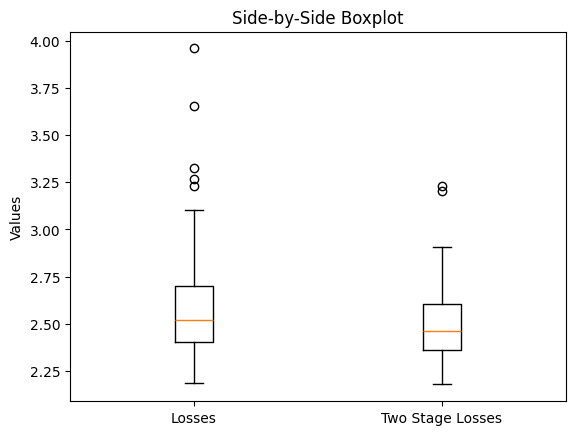

In [20]:
import matplotlib.pyplot as plt

data = [results_df['Losses'], results_df['Two-Stage Losses']]
plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.show()

In [12]:
print(np.mean(losses))
print(np.std(losses))  # Standard deviation
print(np.mean(two_stage_losses))
print(np.std(two_stage_losses))  # Standard deviation
print(np.mean(nbp))
print(np.std(nbp))  # Standard deviation

2.589860598839248
0.2991649522275855
2.4968385031324267
0.19721093342768994
90.2
164.6394849360262


In [13]:
from scipy import stats

t_statistic, p_value = stats.ttest_rel(losses, two_stage_losses)


In [14]:
p_value

2.072596276350502e-05

In [15]:
np.median(random_two_stage_losses)

14356.599370219803